# Lab 6: Convolutional Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow import keras 
import sklearn
from sklearn.preprocessing import StandardScaler

In [104]:
def load_names(file):
    with open(file, 'rb') as fl:
        batch = pickle.load(fl, encoding='latin1')
    
    label_names = batch['label_names']
    return label_names

def load_data(file):
    with open(file, 'rb') as fl:
        batch = pickle.load(fl, encoding='latin1')
        
    features = batch['data']
    labels = batch['labels']
    return features, labels

batch1, label1 = load_data('data_batch_1')
batch2, label2 = load_data('data_batch_2')
batch3, label3 = load_data('data_batch_3')
batch4, label4 = load_data('data_batch_4')
batch5, label5 = load_data('data_batch_5')
X_test, y_test = load_data('test_batch')
label_names = load_names('batches.meta')

#concatenating files 
X_train = np.concatenate([batch1, batch2, batch3, batch4, batch5], 0)
y_train = np.concatenate([label1, label2, label3, label4, label5], 0)
y_test = np.array(y_test)

In [105]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 3072)
(10000, 3072)
(50000,)
(10000,)


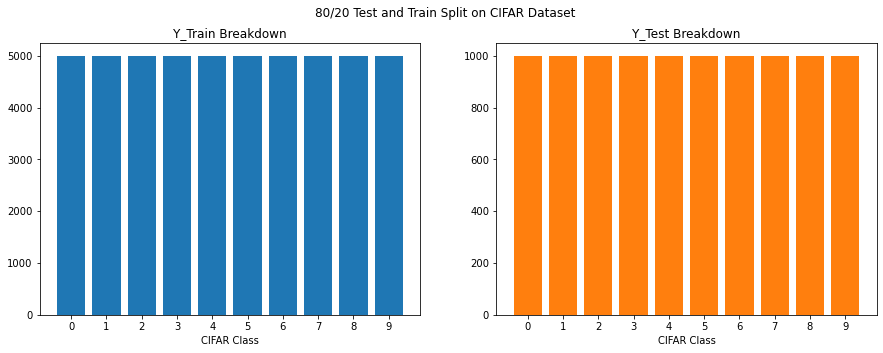

In [106]:
labels = np.arange(10)
train_labels, train_counts =  np.unique(y_train, return_counts=True)
test_labels, test_counts = np.unique(y_test, return_counts=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('80/20 Test and Train Split on CIFAR Dataset')
ax1.bar(train_labels,train_counts, color='tab:blue')
ax2.bar(test_labels,test_counts, color='tab:orange')
ax1.set_title('Y_Train Breakdown')
ax2.set_title('Y_Test Breakdown')
ax1.set_xlabel('CIFAR Class')
ax2.set_xlabel('CIFAR Class')
ax1.set_xticks(labels)
ax2.set_xticks(labels)
plt.show()

## Training-Testing Split Discussion

The CIFAR dataset uploaded from the University of Toronto Department of Computer Science has already splits the training and testing data by 80% and 20% respectively. As you can see from the class distribution aboves, both the training and testing sets are balanced so therefore is no need to split or stratify the data futhermore.  

## Preparation

[1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

## Metric Selection

The metrics that we will use to evaluate each algorithm will be the classification accuracy as well as the confusion matrix. 

[1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

## Modeling

[1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras ImageGenerator as a pre-processing step OR in the optimization loop. You can also use the Keras-cv augmenter (a separate package: https://keras.io/keras_cv/ Links to an external site.)

## Normalizing Data and Converting to Grayscale

In [107]:
X_train = X_train.reshape((X_train.shape[0],3,32,32))
X_train = X_train.transpose(0,2,3,1)
X_test = X_test.reshape((X_test.shape[0],3,32,32))
X_test = X_test.transpose(0,2,3,1)

#X_train = np.dot(X_train,[.2989,.587,.1140])
#X_test = np.dot(X_test,[.2989,.587,.1140])

print(np.amin(X_train))
print(np.amax(X_train))
print(X_train.shape)
print(X_test.shape)

0
255
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [108]:
instances, height, width, channels = X_train.shape

print('Instances:',instances)
print('Height:', height)
print('Width:', width)
print('Channels:', channels)

Instances: 50000
Height: 32
Width: 32
Channels: 3


## Normalize Input Data

In [109]:
X_train = X_train.reshape((X_train.shape[0],height*width*channels))
X_test = X_test.reshape((X_test.shape[0],height*width*channels))

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

X_train = X_train.reshape((X_train.shape[0],height,width, channels))
X_test = X_test.reshape((X_test.shape[0],height,width,channels))

print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [110]:
print(np.amin(X_train))
print(np.amax(X_train))

0.0
1.0


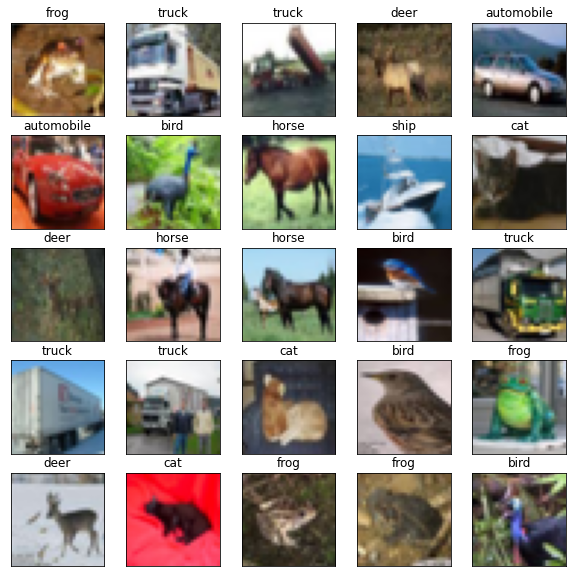

In [111]:
fig = plt.figure(figsize=(10,10))
for i in range(1,26):
    fig.add_subplot(5,5, i)
    plt.imshow(X_train[i-1], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    plt.title('{}'.format(label_names[y_train[i-1]]))

plt.show()

## Data Expansion Using Keras

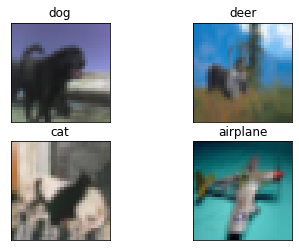

In [112]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
    )

test_datagen = ImageDataGenerator()

#Visualing augmentation
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4, seed=None):
    for i in range(0,4):
        plt.subplot(220+1+i)
        plt.imshow(X_batch[i], cmap=plt.cm.gray)
        plt.xticks([])
        plt.yticks([])
        plt.title('{}'.format(label_names[y_batch[i]]))
    plt.show()
    break

## One Hot Encoding of Target Data

In [113]:
num_classes = 10
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)
print(y_train.shape)
print(y_test.shape)

(50000, 1)
(10000, 1)


In [114]:
y_train_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_hot = keras.utils.to_categorical(y_test, num_classes)
print(y_train_hot.shape)
print(y_test_hot.shape)

(50000, 10)
(10000, 10)


In [118]:
def loss_plot(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss Plot')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Multi-Layer Perceptron

In [116]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [122]:
%%time
mlp = Sequential()
mlp.add( Flatten() )
mlp.add( Dense(input_dim=3072, units=256, activation='relu') )
mlp.add( Dense(units=128, activation='relu') )
mlp.add( Dense(units=64, activation='relu') )
mlp.add( Dense((num_classes), activation='softmax'))

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = mlp.fit(train_datagen.flow(X_train, y_train_hot,batch_size=128), 
        steps_per_epoch = int(len(X_train)/128),
        epochs=10, 
        verbose=1,
        validation_data=test_datagen.flow(X_test,y_test_hot, batch_size=128), 
        validation_steps=len(X_test)/128)

Epoch 1/10
390/390 [==============================] - 49s 123ms/step - loss: 2.1098 - accuracy: 0.2392 - val_loss: 1.8783 - val_accuracy: 0.3159
Epoch 2/10
390/390 [==============================] - 52s 133ms/step - loss: 1.8740 - accuracy: 0.3211 - val_loss: 2.0190 - val_accuracy: 0.2879
Epoch 3/10
390/390 [==============================] - 53s 136ms/step - loss: 1.7966 - accuracy: 0.3535 - val_loss: 1.7471 - val_accuracy: 0.3908
Epoch 4/10
390/390 [==============================] - 51s 130ms/step - loss: 1.7434 - accuracy: 0.3739 - val_loss: 1.7322 - val_accuracy: 0.3831
Epoch 5/10
390/390 [==============================] - 55s 140ms/step - loss: 1.7049 - accuracy: 0.3886 - val_loss: 1.5734 - val_accuracy: 0.4422
Epoch 6/10
390/390 [==============================] - 62s 159ms/step - loss: 1.6761 - accuracy: 0.3978 - val_loss: 1.6190 - val_accuracy: 0.4226
Epoch 7/10
390/390 [==============================] - 64s 164ms/step - loss: 1.6568 - accuracy: 0.4061 - val_loss: 1.5633 - val_ac

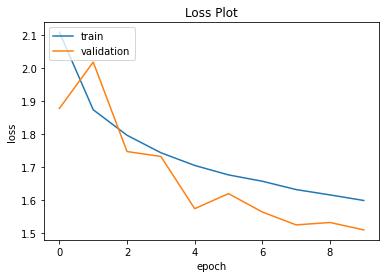

In [123]:
loss_plot(history)

In [125]:
%%time

cnn1 = Sequential()
cnn1.add(Conv2D(filters=16,
                input_shape=X_train.shape[1:],
                kernel_size=(2,2),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn1.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(2,2),
                padding='same',
                activation='relu',))

cnn1.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))
cnn1.add(Flatten())
cnn1.add(Dense(256,activation='relu'))
cnn1.add(Dense(num_classes))
cnn1.add(Activation('softmax'))

cnn1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = cnn1.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=5, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/5
390/390 [==============================] - 51s 128ms/step - loss: 1.6443 - accuracy: 0.4095 - val_loss: 1.3452 - val_accuracy: 0.5234
Epoch 2/5
390/390 [==============================] - 54s 139ms/step - loss: 1.3560 - accuracy: 0.5150 - val_loss: 1.1559 - val_accuracy: 0.5860
Epoch 3/5
390/390 [==============================] - 61s 155ms/step - loss: 1.2285 - accuracy: 0.5619 - val_loss: 1.0921 - val_accuracy: 0.6132
Epoch 4/5
390/390 [==============================] - 68s 173ms/step - loss: 1.1533 - accuracy: 0.5914 - val_loss: 1.0100 - val_accuracy: 0.6375
Epoch 5/5
390/390 [==============================] - 67s 170ms/step - loss: 1.0930 - accuracy: 0.6138 - val_loss: 1.1642 - val_accuracy: 0.6122
CPU times: total: 33min 9s
Wall time: 5min


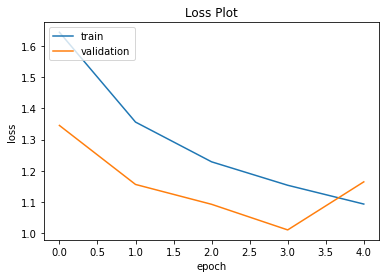

In [126]:
loss_plot(history)

In [128]:
%%time

cnn2 = Sequential()
cnn2.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn2.add(Conv2D(filters=64,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))

cnn2.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))
cnn2.add(Flatten())
cnn2.add(Dense(256,activation='relu'))
cnn2.add(Dense(num_classes))
cnn2.add(Activation('softmax'))

cnn2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = cnn2.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=5, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/5
390/390 [==============================] - 77s 194ms/step - loss: 1.6417 - accuracy: 0.4200 - val_loss: 1.4448 - val_accuracy: 0.5143
Epoch 2/5
390/390 [==============================] - 87s 223ms/step - loss: 1.2565 - accuracy: 0.5539 - val_loss: 1.2085 - val_accuracy: 0.5778
Epoch 3/5
390/390 [==============================] - 116s 297ms/step - loss: 1.1080 - accuracy: 0.6114 - val_loss: 0.9821 - val_accuracy: 0.6565
Epoch 4/5
390/390 [==============================] - 116s 296ms/step - loss: 1.0273 - accuracy: 0.6373 - val_loss: 1.0546 - val_accuracy: 0.6433
Epoch 5/5
390/390 [==============================] - 106s 270ms/step - loss: 0.9698 - accuracy: 0.6601 - val_loss: 0.8442 - val_accuracy: 0.7046
CPU times: total: 55min 3s
Wall time: 8min 21s


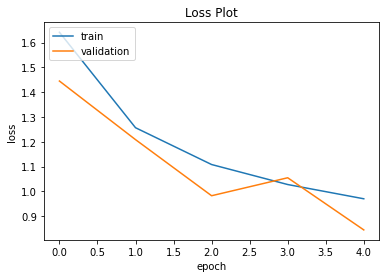

In [129]:
loss_plot(history)

In [134]:
%%time

cnn3 = Sequential()
cnn3.add(Conv2D(filters=16,
                input_shape=X_train.shape[1:],
                kernel_size=(2,2),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn3.add(Conv2D(filters=16,
                input_shape=X_train.shape[1:],
                kernel_size=(2,2),
                padding='same',
                activation='relu',))

cnn3.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))

cnn3.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(2,2),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn3.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(2,2),
                padding='same',
                activation='relu',))

cnn3.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))

cnn3.add(Flatten())
cnn3.add(Dense(256,activation='relu'))
cnn3.add(Dense(num_classes))
cnn3.add(Activation('softmax'))

cnn3.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = cnn3.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=5, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/5
390/390 [==============================] - 58s 144ms/step - loss: 1.7478 - accuracy: 0.3722 - val_loss: 1.4120 - val_accuracy: 0.4988
Epoch 2/5
390/390 [==============================] - 56s 144ms/step - loss: 1.4218 - accuracy: 0.4913 - val_loss: 1.2135 - val_accuracy: 0.5626
Epoch 3/5
390/390 [==============================] - 54s 139ms/step - loss: 1.2832 - accuracy: 0.5408 - val_loss: 1.1568 - val_accuracy: 0.5864
Epoch 4/5
390/390 [==============================] - 59s 151ms/step - loss: 1.1866 - accuracy: 0.5773 - val_loss: 1.0523 - val_accuracy: 0.6230
Epoch 5/5
390/390 [==============================] - 54s 137ms/step - loss: 1.1186 - accuracy: 0.6019 - val_loss: 0.9620 - val_accuracy: 0.6576
CPU times: total: 32min 44s
Wall time: 4min 42s


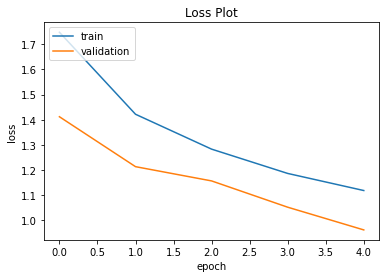

In [135]:
loss_plot(history)

In [138]:
%%time

cnn4 = Sequential()
cnn4.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn4.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))

cnn4.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))

cnn4.add(Conv2D(filters=64,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn4.add(Conv2D(filters=64,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))

cnn4.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))

cnn4.add(Flatten())
cnn4.add(Dense(256,activation='relu'))
cnn4.add(Dense(num_classes))
cnn4.add(Activation('softmax'))

cnn4.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = cnn4.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=5, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/5
390/390 [==============================] - 87s 220ms/step - loss: 1.7310 - accuracy: 0.3746 - val_loss: 1.3133 - val_accuracy: 0.5309
Epoch 2/5
390/390 [==============================] - 101s 259ms/step - loss: 1.2892 - accuracy: 0.5382 - val_loss: 1.0259 - val_accuracy: 0.6463
Epoch 3/5
390/390 [==============================] - 100s 255ms/step - loss: 1.0976 - accuracy: 0.6080 - val_loss: 0.9657 - val_accuracy: 0.6528
Epoch 4/5
390/390 [==============================] - 99s 254ms/step - loss: 0.9789 - accuracy: 0.6554 - val_loss: 0.8294 - val_accuracy: 0.7120
Epoch 5/5
390/390 [==============================] - 93s 237ms/step - loss: 0.8907 - accuracy: 0.6864 - val_loss: 0.8502 - val_accuracy: 0.7008
CPU times: total: 55min 2s
Wall time: 8min


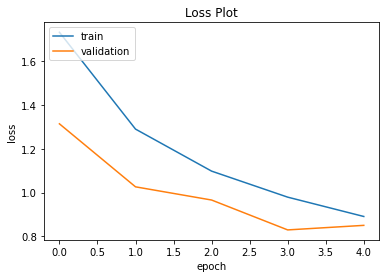

In [139]:
loss_plot(history)

In [157]:
import seaborn as sns

def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('Model 1: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('Model 2: '+str(acc_mlp))

313/313 [==============================] - 1s 4ms/step


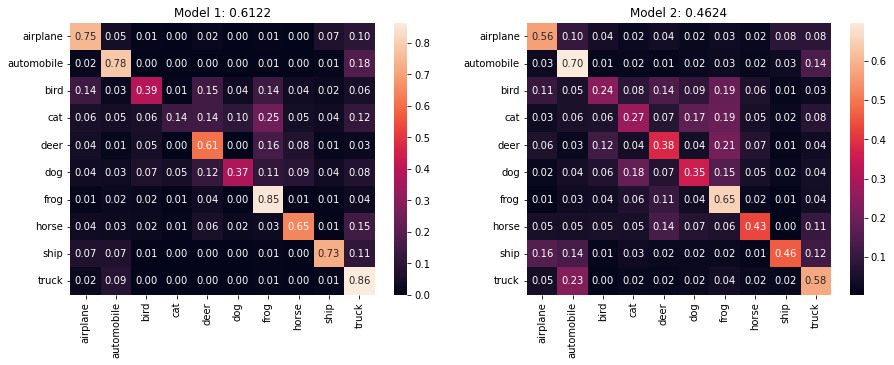

In [158]:
compare_mlp_cnn(cnn1,mlp,X_test,y_test,label_names)

313/313 [==============================] - 3s 9ms/step


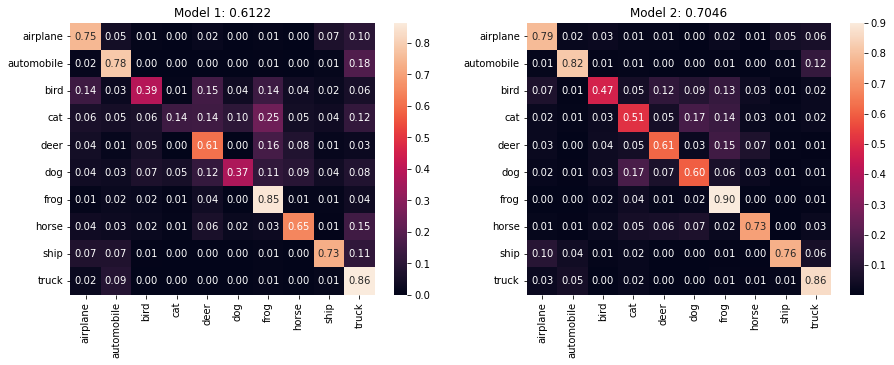

In [148]:
compare_mlp_cnn(cnn1,cnn2,X_test,y_test,label_names)

313/313 [==============================] - 3s 9ms/step


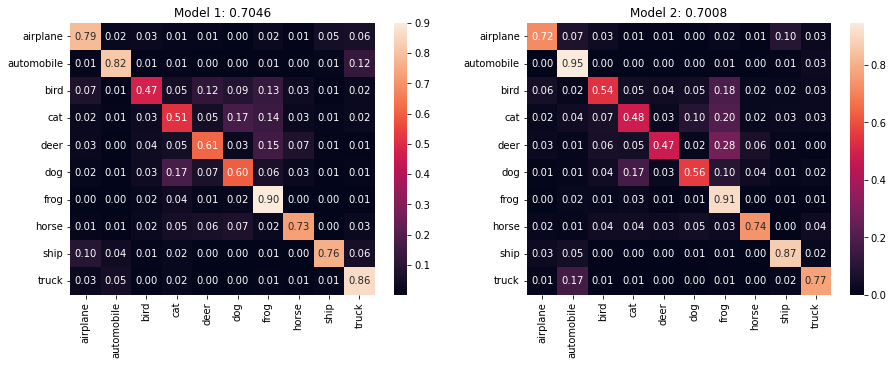

In [149]:
compare_mlp_cnn(cnn2,cnn4,X_test,y_test,label_names)

313/313 [==============================] - 1s 3ms/step


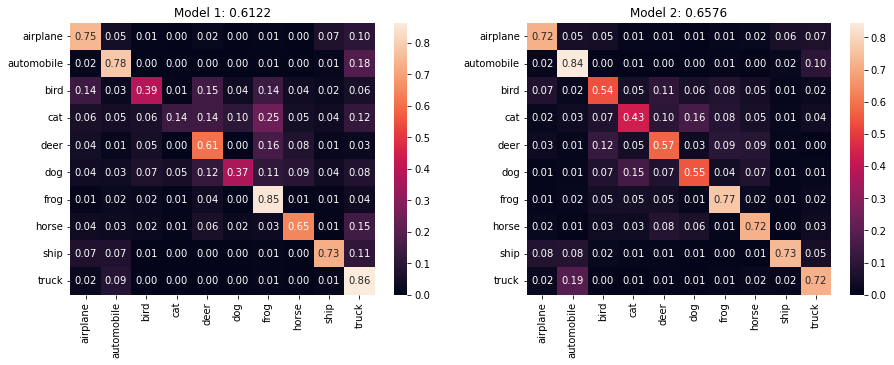

In [166]:
compare_mlp_cnn(cnn1,cnn3,X_test,y_test,label_names)

[2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture such as the number of filters--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

[1.5 points] Visualize the final results of the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models. 

[1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

In [256]:
ypred4 = cnn4.predict(X_train)
ypred4 = ypred4.argmax(axis=-1)
ypred4

1563/1563 [==============================] - 37s 24ms/step


array([6, 9, 9, ..., 9, 1, 1], dtype=int64)

In [257]:
ypred3 = cnn3.predict(X_train)
ypred3 = ypred3.argmax(axis=-1)
ypred3

1563/1563 [==============================] - 14s 9ms/step


array([6, 9, 9, ..., 9, 1, 1], dtype=int64)

In [258]:
ypred2 = cnn2.predict(X_train)
ypred2 = ypred2.argmax(axis=-1)
ypred2

1563/1563 [==============================] - 36s 23ms/step


array([6, 9, 9, ..., 9, 1, 1], dtype=int64)

In [259]:
ypred1 = cnn1.predict(X_train)
ypred1 = ypred1.argmax(axis=-1)
ypred1

1563/1563 [==============================] - 14s 9ms/step


array([6, 9, 9, ..., 9, 1, 9], dtype=int64)

In [227]:
ypred_mlp = mlp.predict(X_train)
ypred_mlp = ypred_mlp.argmax(axis=-1)
ypred_mlp

1563/1563 [==============================] - 8s 5ms/step


array([6, 1, 9, ..., 9, 1, 7], dtype=int64)

In [241]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(label_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

ROC AUC score: 0.7038555555555556


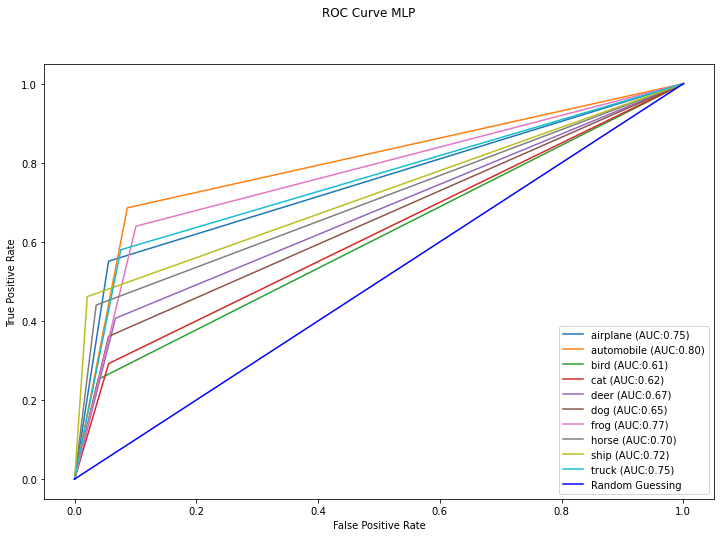

In [271]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score:', multiclass_roc_auc_score(y_train, ypred_mlp))
fig.suptitle('ROC Curve MLP')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score: 0.791611111111111


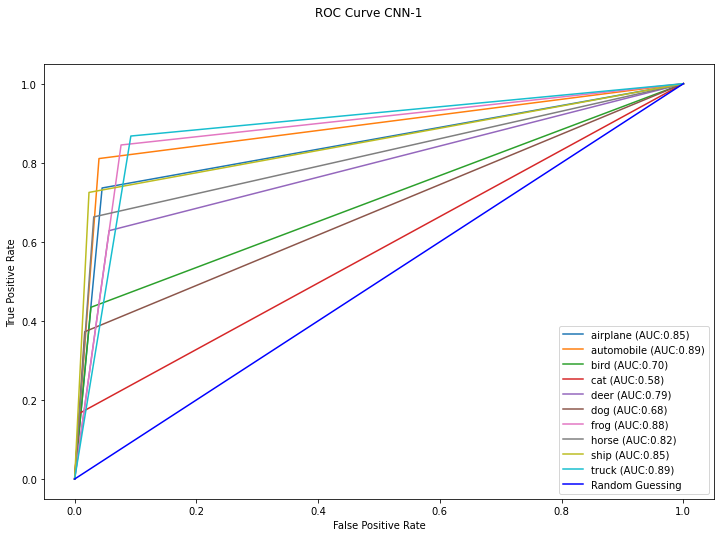

In [270]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred1))
fig.suptitle('ROC Curve CNN-1')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score: 0.8503555555555555


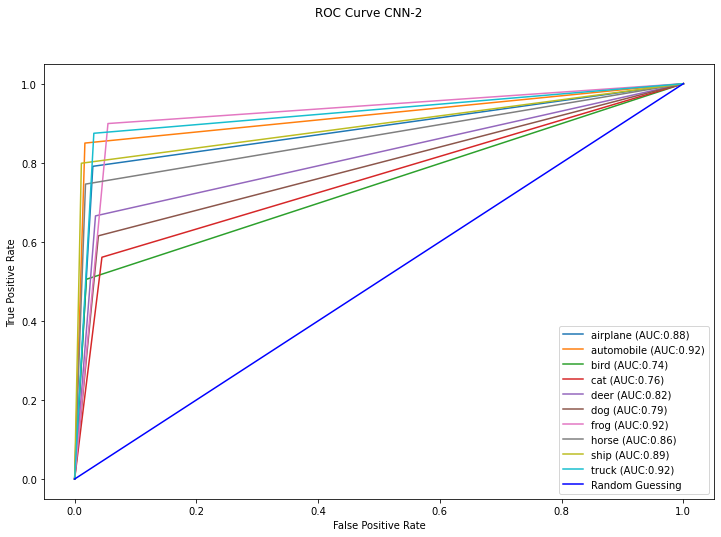

In [269]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred2))
fig.suptitle('ROC Curve CNN-2')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score: 0.8191333333333333


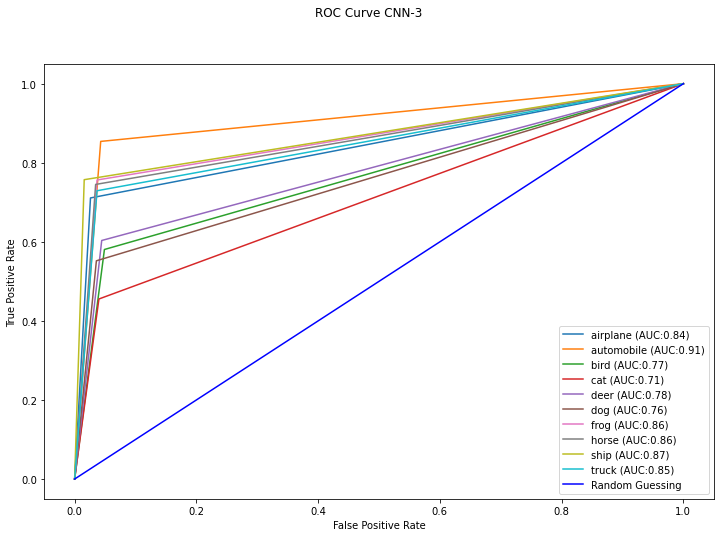

In [268]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred3))
fig.suptitle('ROC Curve CNN-3')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score: 0.8477


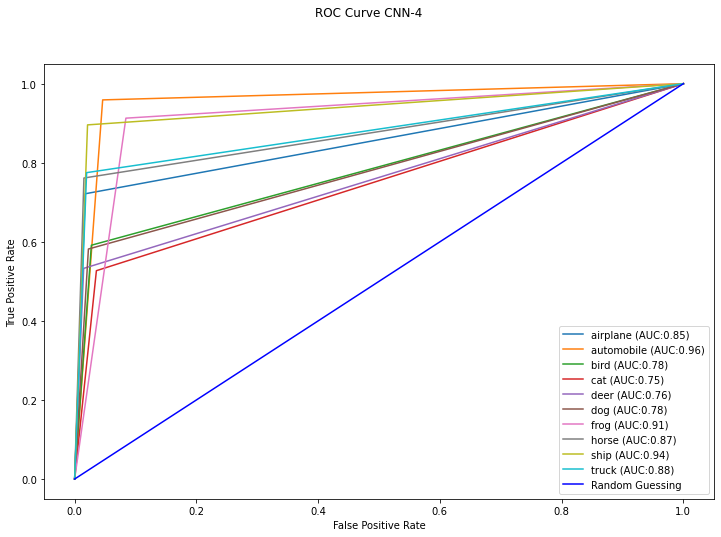

In [267]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred4))
fig.suptitle('ROC Curve CNN-4')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

Cited from: 
https://stackoverflow.com/questions/66635552/keras-assessing-the-roc-auc-of-multiclass-cnn

## Exceptional Work

Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 